# Feature Extraction with *pyspch*

#### Motivating Spectral Features

It is common practice to use spectral features in speech recognition.  Therefore in a first step a Fourier spectrogram is computed using a sliding window with typically a shift of 10 msec.  The phase is discarded and only the log magnitude spectrum is maintained.
This is by all means a much more appealing representation for pattern matching than the raw speech waveform.


#### From Spectrogram to Features

Starting from the log-magnitude spectrum we may still want to apply some additional FEATURE EXTRACTION  with as main purpose to present relevant information to the recognizer and to suppress disturbing, noisy side information at the same time.

This notebook shows how to do 2 prototypical feature extractions for speech recognition

- a.  Mel Frequency Cepstral Coefficients
- b.  High Resolution Mel Frequency Spectrum 

Note: A more detailed demo and test of feature extraction functionalities may be found in tests/feature_test.ipynb 

#### *pyspch* standards and methods

- pyspsch and librosa
    + *pyspch* is built on top of librosa, numpy and scipy
    + *pyspch* uses the spectrogram arrangement (n_params,n_frames) as in librosa
    + *pyspsch* is often just a wrapper around librosa, and certain calls can be interchangeable
    + *pyspch* uses the 'dB' mode by default, but other modes (power, magnitude) can be used at any moment
- pyspch *framing* standards
   + *pyspch* uses the same framing approach as in SPRAAK or KALDI; i.e. frames are solely defined by shift parameter; 
    + frame i is positioned \[ i\*n_shift, (i+1)\*n_shift \] 
    + frame i is symmetrically extended to accomodate n_length and ultimately n_fft
    + padding via mirroring at the signal edges
    + n_frames = n_samples // n_shift
    + calling preemp_pad() prepares the waveform for processing with librosa 'without centering frames'
- mel spectrum
    + librosa defaults to conversion of full range spectrum
    + *pyspch* uses a smaller range, similar but not exact to kaldi 

In [42]:
%matplotlib inline
import os,sys, math, copy
import numpy as np
import librosa

import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd

import matplotlib.pyplot as plt
import matplotlib as mpl
import ipywidgets as widgets
from ipywidgets import interactive

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

### 1. Load a Waveform File

In [43]:
dir = 'https://homes.esat.kuleuven.be/~spchlab/data/'
name = 'misc/bad_bead_booed'
#name ='misc/b_8k'
name = 'misc/friendly'
#name = 'timit/si1027'
#
wavfname = os.path.join(dir,name+".wav")
wavdata, sr = Spch.load(wavfname)
if sr > 16000:  wavdata, sr = Spch.load(wavfname,sample_rate=16000) 


### 2. Fourier Spectrogram

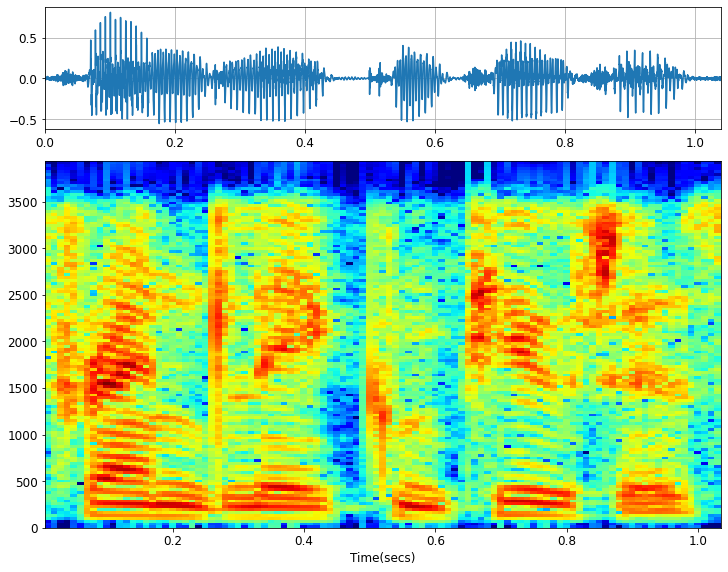

In [44]:
# compute a spectrogram as starting point for further analysis
shift=0.01
length=0.030
n_shift = int(shift*sr)
n_length = int(length*sr)
n_fft = 2**math.ceil(math.log2(n_length))
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift,n_mels=None,mode='dB')
(n_param,n_frames)=spg.shape
d_freq = sr/(2.*(n_param-1))
fig = Spd.PlotSpg(wavdata=wavdata,spgdata=spg,sample_rate=sr,figsize=(10,8))
fig

In [19]:
# spectrogram with sliding window
def sliding_window_spg(iframe=1):
    fig.remove_patches()
    fig.add_vrect((iframe-1)*shift,(iframe+2)*shift,iax=0,ec=None,fill=True)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=1)
    display(fig)
#
frame_slider=widgets.IntSlider(min=1,max=n_frames-2,value=n_frames/2,
            description='FRAME',layout=widgets.Layout(width='6in'),readout=True )
i_spg=interactive(sliding_window_spg,iframe=frame_slider);
display(i_spg)

interactive(children=(IntSlider(value=52, description='FRAME', layout=Layout(width='6in'), max=102, min=1), Ou…

In [22]:
# spectrogram with sliding window
def sliding_window_spg(iframe=0):
    fig.remove_patches()
    fig.add_vrect((iframe-1)*shift,(iframe+2)*shift,iax=0,ec=None,fill=True)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=1)
    display(fig)
#
frame_slider=widgets.IntSlider(min=1,max=n_frames-2,value=n_frames/2,
            description='i',layout=widgets.Layout(width='8in'),readout=True )

i_spg = widgets.interactive_output(sliding_window_spg,{'iframe':frame_slider})
display(frame_slider,i_spg)


IntSlider(value=52, description='i', layout=Layout(width='8in'), max=102, min=1)

Output()

### 3. Mel Frequency Cepstral Coefficients


**STEP 1. Mel Spectrum**

In a first step the Fourier Spectrum is converted to a mel Spectrum.  By this the frequency axis is warped as inspired by the human auditory system.  The warping corresponds roughly in maintaining the frequency spacing at low frequencies (below 1kHz) and doing a logarithmic compression on the frequency axis as higher frequencies (above 1kHz).  A low resolution is adequate in this pipeline, given that is followed by cepstral modeling.   It is common to use 20 channels for narrowband signals (8kHz sampling rate) and 24 channels for wideband signals.

**STEP 2. Mel Cepstrum**
This is a single frame operation in which the cepstrum is computed of low dimensional representation of spectral envelope.  It can either be computed from the Fourier Spectrum or from the Mel Spectrum.   The default number of cepstral parameters is 13.  An alternative exists in replacing c0 (mean of log-energy per mel band) by the true log-energy.  We don't do this here.

**STEP 3. Delta's and Delta-Delta's**
"Delta's" compute the "trend" over time of the features and double delta's compute a second order derivative.  In practice the derivatives are approximated by simple regression formulas.

$$
\begin{align}
\Delta c_i  &= 2 c_{i+2} + c_{i+1} - c_{i-1} - 2 c_{i-2}  \\
\Delta\Delta c_i &=  \Delta c_{i+1} - \Delta c_{i-1}   
\end{align}
$$

The final feature vector is obtained by stacking instantaneous cepstral features with their delta's and delta-delta's.  Thus resulting in a 39-dimensional feature vector derived from a receptive field of 7 frames.

MFCCs are both compact and highly uncorrelated features.  This makes them suitable in almost all circumstances and for all backends. These features are the reference features for HMM/GMM based systems.  Their main drawback is the limited receptive field. 

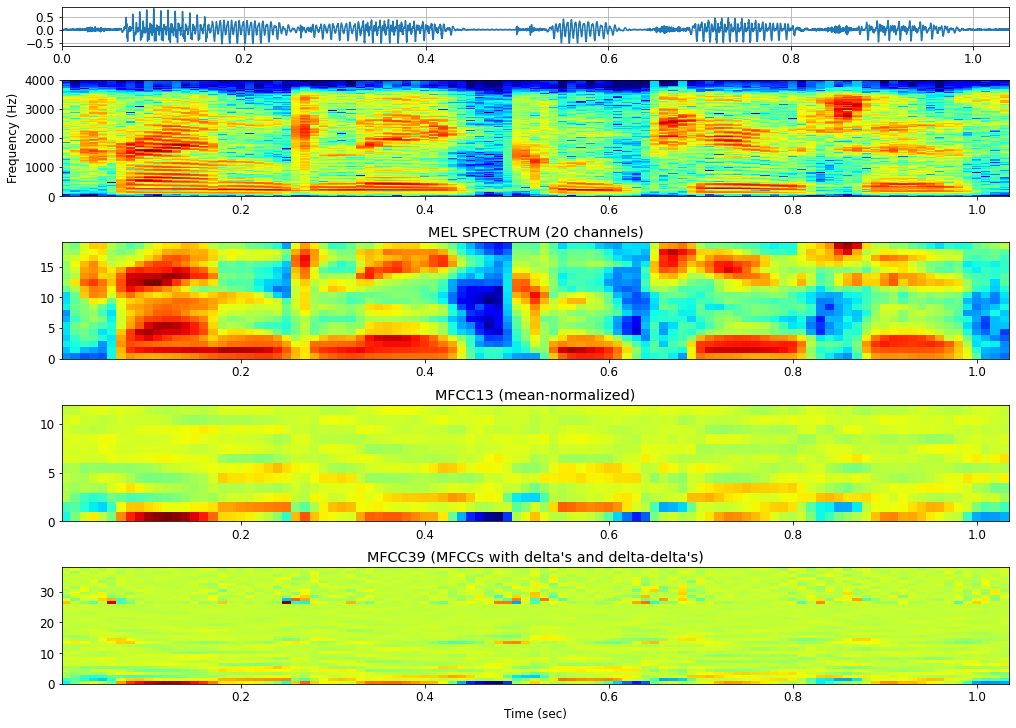

In [23]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
n_mels = 20 if sr == 8000 else 24
spgmel = Sps.spg2mel(spg,sample_rate=sr,n_mels=n_mels)
mfcc13 = Sps.cepstrum(S=spgmel,n_cep=13)
mfcc13_n = Sps.mean_norm(mfcc13)
mfcc39 = Sps.deltas(mfcc13_n,type="delta_delta2",Augment=True)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[spgmel,mfcc13_n,mfcc39],sample_rate=sr,figsize=(14,10))
fig.axes[2].set_title("MEL SPECTRUM (%d channels)" % n_mels)
fig.axes[3].set_title("MFCC13 (mean-normalized)")
fig.axes[4].set_title("MFCC39 (MFCCs with delta's and delta-delta's)")
display(fig)

In [24]:
# MFCCs with sliding window
def sliding_window_mfcc(iframe=0):
    fig.remove_patches()
    fig.add_vrect((iframe-1)*shift,(iframe+2)*shift,iax=0)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=1)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=2)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=3)
    #fig.add_vrect((iframe-3)*shift,(iframe)*shift,iax=3,alpha=.2)
    fig.add_vrect((iframe-3)*shift,(iframe+4)*shift,iax=3,alpha=.1,color='b',fill=True)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=4)
    #print(iframe)
    display(fig)

#
i_mfcc=interactive(sliding_window_mfcc,iframe=widgets.IntSlider(min=3,max=n_frames-4,value=n_frames/2,
            description=' ',layout=widgets.Layout(width='10.2in'),readout=False)
             );
i_mfcc

interactive(children=(IntSlider(value=52, description=' ', layout=Layout(width='10.2in'), min=3, readout=False…

### 4. High Resolution Mel Spectra (with splicing over wide window)

**STEP 1. Mel Spectrum (high resolution)**

In a first step the Fourier Spectrum is converted to a mel Spectrum.  By this the frequency axis is warped as inspired by the human auditory system.  The warping corresponds roughly in maintaining the frequency spacing at low frequencies (below 1kHz) and doing a logarithmic compression on the frequency axis as higher frequencies (above 1kHz).  The high resolution mel spectrum (+- 80 channels) preserves both spectral envelope and pitch information in a single spectral representation.  The high resolution mel spectrum should only be used as a feature vector in systems that can deal with highly correlated features.

**STEP 2. Stacking of Frames**

From a spectral analysis point of view it makes sense to use short analysis windows (30msec).  However from a speech recognition point of view, it is better to observe the short time spectrum in its context.   This is simply achieved by stacking many adjacent vectors together.

We may e.g. stack $N$ frames on the left and the right using a stride of 2 as shown below.  This results in a receptive field of $2(N*s)+1$ frames wide.  Using a stride of 2 allows for a wider span receptive field while maintaining a manageble dimension of the feature vector.  
$$
\underbrace{ 
S_{i-N\times s} \hspace{8pt} \text{...} \hspace{8pt} S_{i-s} \hspace{8pt}  S_i \hspace{8pt} S_{i+s} \hspace{8pt} \text{...} \hspace{8pt}S_{i+N\times s} }_{F_i}
$$


In the implementation below we use 80 dimensional mel spectra, we stack 5 frames to left and right and use a stride of 2 resulting in a receptive field of 210 msec and a feature vector dimension of 880.  Before splicing the mel spectral features are mean and variance normalized.

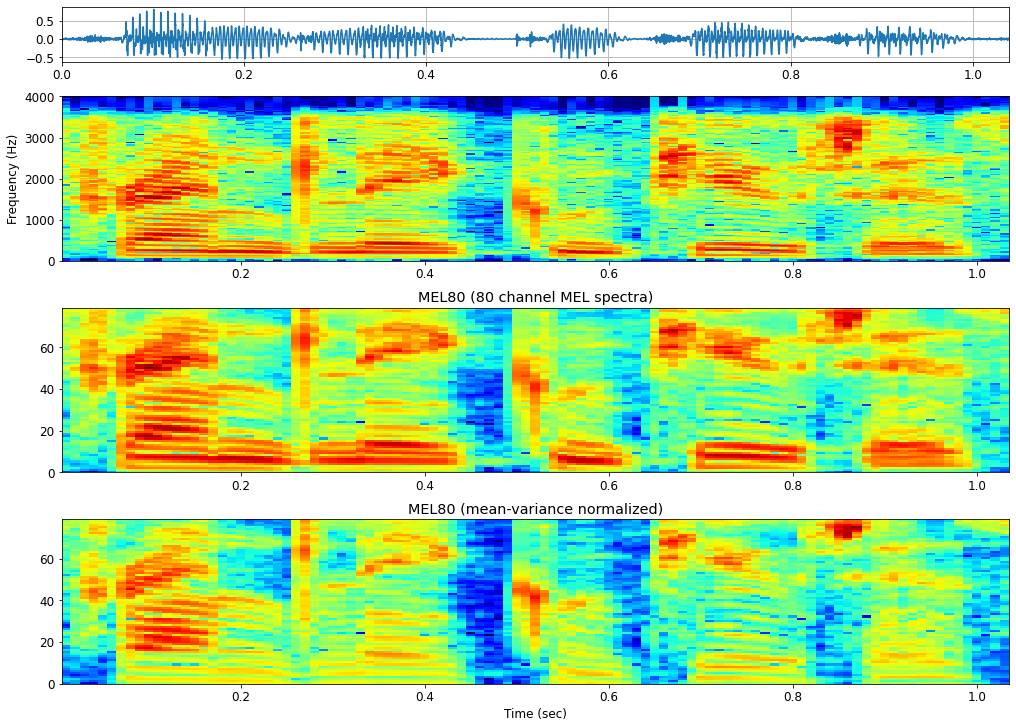

In [39]:
stride = 2
N = 5
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
spgmel = Sps.spg2mel(spg,sample_rate=sr,n_mels=80)
spgmel_n = Sps.mean_norm(spgmel,type="meanvar")
spgmel_s = Sps.splice_frames(spgmel_n,N=N,stride=stride)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[spgmel,spgmel_n],sample_rate=sr,figsize=(14,10))
fig.axes[2].set_title("MEL80 (80 channel MEL spectra)")
fig.axes[3].set_title("MEL80 (mean-variance normalized)")
display(fig)

In [40]:
# MFCCs with sliding window
def sliding_window_mspec(iframe=0):
    fig.remove_patches()
    fig.add_vrect((iframe-1)*shift,(iframe+2)*shift,iax=0)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=1)
    fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=2)
    #fig.add_vrect(iframe*shift,(iframe+1)*shift,iax=3)
    fig.add_vrect((iframe-N*stride)*shift,(iframe+1+N*stride)*shift,iax=3,alpha=.6,fill=True)
    display(fig)
#
i_mfcc=interactive(sliding_window_mspec,iframe=widgets.IntSlider(min=N*stride+1,max=n_frames-N*stride-2,value=n_frames/2,
            description='frame',layout=widgets.Layout(width='6in'))
             );
i_mfcc

interactive(children=(IntSlider(value=52, description='frame', layout=Layout(width='6in'), max=92, min=11), Ou…

## Feature Extraction master routine

The above feature extraction methods can be implemented in a single call

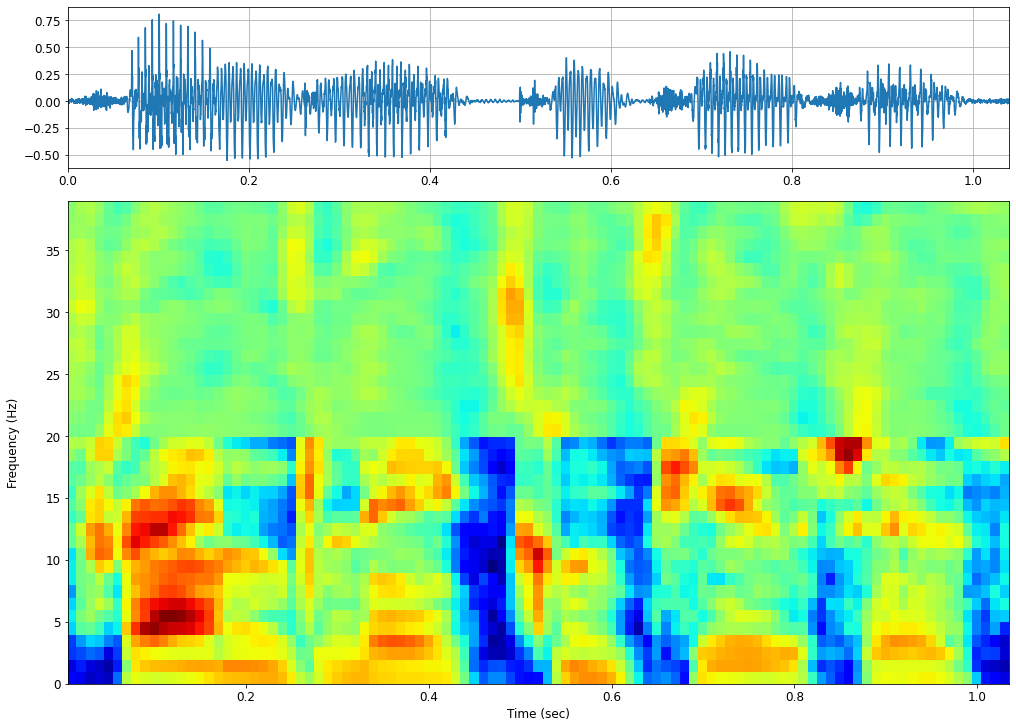

In [41]:
ftrs = Sps.feature_extraction(wavdata,sample_rate=sr,n_mels=20,Deltas="delta",Norm="mean")
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=ftrs,dy=1,sample_rate=sr,figsize=(14,10))
display(fig)

In [ ]:
## some tests with interactive_output
## not suitable in combination with spectrogram plots -- gives flickering

In [4]:
a = widgets.IntSlider()
b = widgets.IntSlider()
c = widgets.IntSlider()
ui = widgets.HBox([a, b, c])
def f(a, b, c):
    print((a, b, c))
    x=1

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

display(ui, out)

Output()

In [5]:
ifr = widgets.IntSlider( min=0,max=n_frames-1,value=n_frames/2,description='',layout=widgets.Layout(width='10in'),readout=False )
def func(a):
    x=1
    print(a)
ifr_disp = widgets.interactive_output(func,{'a':ifr})
display(ifr_disp,widgets.HBox([ifr]) )

Output()